In [1]:
# Import all environments and SRE agent

# Imports

import numpy as np
import plotly.graph_objects as go
import random

import torch
import numpy as np
from collections import deque, namedtuple

#import learning_agents
#from cube_env import Cube,visualise

import torch
import torch.nn as nn  
import torch.nn.functional as F

import numpy as np
import random

import torch
import numpy as np
from collections import deque, namedtuple

import Learning_Agents
import torch.optim as optim


import torch
import torch.nn as nn  
import torch.nn.functional as F

#Importing Environment
from puzzle_env import EightPuzzle, FourPuzzle

In [2]:
# Environment building

env = FourPuzzle()
n = 4
new_env_rep = FourPuzzle()
new_env_scr = FourPuzzle()

state = env.reset()

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

fin_goal = env.goal_state.flatten()
print(fin_goal)

[1 2 3 0]


In [9]:
# Building SRE-NITR (Complete Updated)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def dqn_sre(n_episodes=1000, max_t=8*n, eps_start=1.0, eps_end=0.1, eps_decay=0.9995):
    print(pow(eps_decay,n_episodes))

    scores = []                 # list containing scores from each episode
    scores_window_printing = deque(maxlen=10) # For printing in the graph
    scores_window = deque(maxlen=100)  # last 100 scores for checking if the avg is more than 195
    eps = eps_start                    # initialize epsilon
    
    candidate_goals = deque(maxlen=20)
    candidate_itrs_tau = deque(maxlen=20)
    candidate_itrs_invtau = deque(maxlen=20)

    
    # Obtaining the start and end state for Tau and Tau_inv
    start_tau = env.get_state()
    goal_tau = env.goal_state.flatten()
    start_tau_inv = env.goal_state.flatten()
    goal_tau_inv = env.get_state()

    #Starting the whole run :)
    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        fin_goal = env.goal_state.flatten()
        score_main = 0
        done = False
        
        traj_val = []
         
        # Run for one trajectory (Original Task for evaluation)
        for t in range(max_t):
            
            #We store all we need for each trajectory
            
            #Choosing an action
            action = agent.act(np.concatenate((state,fin_goal)), eps)

            #Executing that action
            next_state, reward, done, _ = env.step(action)

            traj_val.append([state,action,reward,next_state,done])
            
            state = next_state
            score_main += reward
            
            if done:
                break 
                
        scores.append(score_main)  # save most recent score (For Eval purposes)
        
        # Hindsight relabelling of this trajectory:
        final_state = next_state
        
        # Hindsight relabelling for the explorer run
        for sublist in traj_val:
            new_state = np.concatenate((sublist[0],final_state))
            new_next_state = np.concatenate((sublist[3],final_state))
            #print('traj',new_state, sublist[1], sublist[2], new_next_state, sublist[4])
            reward = sublist[2]
            

            if (sublist[3] == final_state).all():
                reward = 1
                    
            #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
            agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])
            
                
        # Adding Hindsight Goals if final state is not in candidates:
        candidate = next_state
        if not done:
            flag = 0
            
            #If not in hindsight_goals, then add to it
            if len(candidate_goals) == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))
                
            for hind_goal in candidate_goals:
                if (candidate == hind_goal).all():
                    flag = 1
                    
            if flag == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))
        #print(len(traj_val))
        
        ####################### Running EXPLORER Module: ##############################
        # ITR Phase: Choosing a task_itr_goal (Task - tau)
        if len(candidate_goals) == 0:
            itr_goal_exp = goal_tau
        else:
            itr_goal_exp =  random.choices(candidate_goals, candidate_itrs_tau)[0]
            
        done = False
        # Running the explorer run with itr_goal_exp as the desired goal state
        state = env.reset()
        traj_val = []
        reward = 0
        score = 0
        
        
        for t in range(max_t):
            
            #Choosing an action
            action = agent.act(np.concatenate((state,itr_goal_exp)), eps)
            #Executing that action
            next_state, reward, done, _ = env.step(action) 
            
            traj_val.append([state,action,reward,next_state,done])
            
            state = next_state
            score += reward
            
            if done:
                break 
                
        # Adding Hindsight Goals if final state is not in candidates:
        candidate = next_state
        
        if not done:
            flag = 0
            
            #If not in hindsight_goals, then add to it
            if len(candidate_goals) == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))
                
            for hind_goal in candidate_goals:
                if (candidate == hind_goal).all():
                    flag = 1
                    
            if flag == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))
        
        
        
        # Hindsight relabelling for the explorer run
        final_state = next_state
        
        for sublist in traj_val:
            new_state = np.concatenate((sublist[0],final_state))
            new_next_state = np.concatenate((sublist[3],final_state))
            #print('traj',new_state, sublist[1], sublist[2], new_next_state, sublist[4])
            reward = sublist[2]

            if (sublist[3] == final_state).all():
                reward = 1

            #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
            agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])
        
        #############################################################
        ###################### SCRAMBLER MODULE #####################
        #############################################################

        ############ Scrambler run with tau^star_inv as task ###########################
        itr_goal_scr = goal_tau_inv

        new_env_scr.init_state(start_tau_inv)
        state = new_env_scr.get_state()
        reward = 0
        done = False
        traj_val = []
        #print('fin_goal',fin_goal)
        
        for i in range(max_t):
            
            #Scrambler Part
            action = agent.scr_act(np.concatenate((state,itr_goal_scr)), eps)
            
            #Executing that action
            next_state, reward, done, _ = new_env_scr.step(action) 
                
            #tempf_state, reward, scr_done , _ = new_env_scr.step(rev_action)
            traj_val.append([state,action,reward,next_state,done])

            if done:
                pass
            
        # Hindsight relabelling for the scrambler run
        final_state = next_state
        
        for sublist in traj_val:
            new_state = np.concatenate((sublist[0],final_state))
            new_next_state = np.concatenate((sublist[3],final_state))
            #print('traj',new_state, sublist[1], sublist[2], new_next_state, sublist[4])
            reward = sublist[2]

            if (sublist[3] == final_state).all():
                reward = 1

            #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
            agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])

            
        # Adding Hindsight Goals if final state is not in candidates:
        candidate = next_state
        
        if not done:
            flag = 0
            
            #If not in hindsight_goals, then add to it
            if len(candidate_goals) == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))
                
            for hind_goal in candidate_goals:
                if (candidate == hind_goal).all():
                    flag = 1
                    
            if flag == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))

        ############ Scrambler run with tau^star_inv-itr as task ###########################

        #Obtain goal for scrambler using itr_inv
        if len(candidate_goals) == 0:
            itr_goal_scr = goal_tau_inv
        else:
            itr_goal_scr =  random.choices(candidate_goals, candidate_itrs_invtau)[0]
        
        #Start a new environment from the goal to generate samples
        new_env_scr.init_state(start_tau_inv)
        state = new_env_scr.get_state()
        reward = 0
        done = False
        traj_val = []
        #print('fin_goal',fin_goal)
        
        for i in range(max_t):
            
            #Scrambler Part
            action = agent.scr_act(np.concatenate((state,itr_goal_scr)), eps)
                
            #Executing that action
            next_state, reward, done, _ = new_env_scr.step(action) 
                
            #tempf_state, reward, scr_done , _ = new_env_scr.step(rev_action)
            traj_val.append([state,action,reward,next_state,done])

            if done:
                pass
            
        ## TODO: Add this, the final state to the candidate list?
        # Adding Hindsight Goals if final state is not in candidates:
        candidate = next_state
        
        if not done:
            flag = 0
            
            #If not in hindsight_goals, then add to it
            if len(candidate_goals) == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))
                
            for hind_goal in candidate_goals:
                if (candidate == hind_goal).all():
                    flag = 1
                    
            if flag == 0:
                candidate_goals.append(candidate)
                candidate_itrs_tau.append(agent.itr_priority(start_tau,candidate,goal_tau))
                candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,candidate,goal_tau_inv))

        # Scrambler hindsight relabelling:
        final_state = next_state
        
        for sublist in traj_val:
            new_state = np.concatenate((sublist[0],final_state))
            new_next_state = np.concatenate((sublist[3],final_state))
            #print('traj',new_state, sublist[1], sublist[2], new_next_state, sublist[4])
            reward = sublist[2]

            if (sublist[3]== final_state).all():
                reward = 1

            #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
            agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])
  

        ####################### REPEATER MODULE #######################
        
        #We start the repeater from the last state of the scrambler
        rep_state = next_state
        done = False
        reward = 0
        traj_val = []

            
        new_env_rep.init_state(rep_state)
            #print('rep_state',rep_state)
        state = rep_state
            
        for _ in range(max_t):
                
            #Choosing an action
            action = agent.scr_act(np.concatenate((state,goal_tau)), eps) 

            #Executing that action
            next_state, reward, done, _ = new_env_scr.step(action) 

            traj_val.append([state,action,reward,next_state,done])
            
            if done:
                break
                
        # Hindsight relabelling for repeater trajectories
        final_state = next_state
        
        for sublist in traj_val:
            new_state = np.concatenate((sublist[0],final_state))
            new_next_state = np.concatenate((sublist[3],final_state))
            #print('traj',new_state, sublist[1], sublist[2], new_next_state, sublist[4])
            reward = sublist[2]

            if (sublist[3] == final_state).all():
                reward = 1

            #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
            agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])
        
    
        #Training (Refer to HER algorithm)
        for _ in range(max_t):
            agent.train_call()
            
        # Re evaluating itr values after training the agent:
        
        candidate_itrs_tau = deque(maxlen=20)
        candidate_itrs_invtau = deque(maxlen=20)
        
        for c in candidate_goals:
            candidate_itrs_tau.append(agent.itr_priority(start_tau,c,goal_tau))
            candidate_itrs_invtau.append(agent.itr_priority(start_tau_inv,c,goal_tau_inv))

        
        scores_window.append(score_main)             # save most recent score
        eps = max(eps_end, eps_decay*eps)                 # decrease epsilon
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score_main), end="")        
        if i_episode % 100 == 0: 
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return [np.array(scores),i_episode-100]

In [10]:
# Running an algorithm 5 times for different seeds and averaging the performance

device = torch.device("cpu")

# seed = 0
agent = Learning_Agents.Agent_SREDQN(state_size=state_shape,action_size = action_shape,seed = 0)
scores_dqn_1, terminal_ep_dqn_1 = dqn_sre(n_episodes=100000, max_t=10*n, eps_start=1.0, eps_end=0.1, eps_decay=0.99995)

# seed = 1
agent = Learning_Agents.Agent_SREDQN(state_size=state_shape,action_size = action_shape,seed = 1)
scores_dqn_2, terminal_ep_dqn_2 = dqn_sre(n_episodes=100000, max_t=10*n, eps_start=1.0, eps_end=0.1, eps_decay=0.99995)

# seed = 2
agent = Learning_Agents.Agent_SREDQN(state_size=state_shape,action_size = action_shape,seed = 2)
scores_dqn_3, terminal_ep_dqn_3 = dqn_sre(n_episodes=100000, max_t=10*n, eps_start=1.0, eps_end=0.1, eps_decay=0.99995)

avg_performance = (scores_dqn_1 + scores_dqn_2 + scores_dqn_3)/3

np.save('array_file.npy', avg_performance)

# Plot the average performance

0.006737104780279986
[1 2 3 0]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
Episode 1	Score: 1.00[2 3 1 0]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[0 2 1 3]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
Episode 2	Score: 1.00[2 0 3 1]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 1 0 3]
[1 2 3 0]
[0 1 2 3]
[1 2 3 0]
[2 1 0 3]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 0 3 1]
[1 2 3 0]
[0 2 3 1]
[1 2 3 0]
[0 2 3 1]
[1 2 3 0]
[2 0 3 1]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 1 3 0]
[1 2 3 0]
[2 0 3 1]
[1 2 3 

Episode 14	Score: 0.00[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[1 0 3 2]
[1 2 3 0]
Episode 15	Score: 1.00[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3

Episode 29	Score: 0.00[2 3 0 1]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[1 0 3 2]
[1 2 3 0]
[1 0 3 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[1 0 3 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[1 0 3 2]
[1 2 3 0]
Episode 30	Score: 1.00[3 0 1 2]
[1 2 3 0]
[3 2 1 0]
[1 2 3 0]
[3 0 1 2]
[1 2 3 0]
[3 0 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[3 0 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[3 0 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[0 3 1 2]
[1 2 3 0]
[3 0 1 2]
[1 2 3 0]
[3 2 1 0]
[1 2 3 0]
[3 2 0 1]
[1 2 3 0]
[3 2 0 1]
[1 2 3 0]
[3 2 0 1]
[1 2 3 0]
[3 2 0 1]
[1 2 3

Episode 41	Score: 1.00[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[0 2 1 3]
[1 2 3 0]
[0 2 1 3]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 0 1 3]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 1 0]
[1 2 3 0]
[2 3 0 1]
[1 2 3 0]
[0 3 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 0 2 1]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[0 1 3 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 0 2]
[1 2 3 0]
[3 1 2 0]
[1 2 3 0]
Episode 42	Score: 0.00[1 2 0 3]
[1 2 3 0]
[1 2 0 3]
[1 2 3 0]
Episode 43	Score: 1.00[3 0 1 2]
[1 2 3 0]
[3 2 1 0]
[1 2 3 0]
[3 2 1 0]
[1 2 3 0]
[3 2 1 0]
[1 2 3 0]
[3 2 1 0]
[1 2

KeyboardInterrupt: 

# Printing learning curve
import matplotlib.pyplot as plt

def plot_learning_curve(rewards, moving_avg_period=100):
    plt.figure(figsize=(10,5))
    plt.title("Learning Curve")
    #plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    # Compute and plot moving average
    moving_avg = [np.mean(rewards[max(0, i - moving_avg_period):(i+1)]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=f"Moving Average (last {moving_avg_period} episodes)", color='red')
    
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming scores_dqn is a list of rewards obtained per episode
plot_learning_curve(scores_dqn)

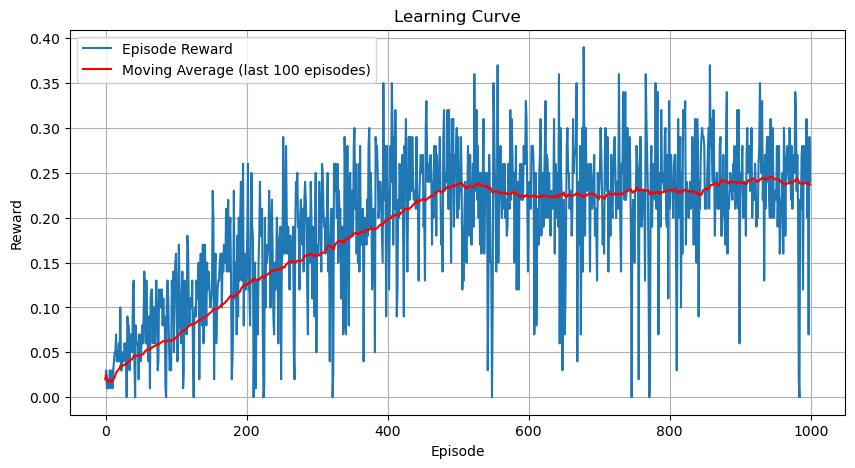

In [11]:
# Printing learning curve
import matplotlib.pyplot as plt

def plot_learning_curve(rewards, moving_avg_period=100):
    plt.figure(figsize=(10,5))
    plt.title("Learning Curve")
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    # Compute and plot moving average
    moving_avg = [np.mean(rewards[max(0, i - moving_avg_period):(i+1)]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=f"Moving Average (last {moving_avg_period} episodes)", color='red')
    
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming scores_dqn is a list of rewards obtained per episode
plot_learning_curve(scores_dqn)

# Checking with Trajectories

In [47]:
BUFFER_SIZE = 20000 # replay buffer size
BATCH_SIZE = 32        # minibatch size
GAMMA = 0.9           # discount factor
LR = 5e-3              # learning rate 
UPDATE_EVERY = 30        # how often to update the network (When Q target is present)

In [48]:
class Agent_DQNHER():

    def __init__(self, state_size, action_size, seed):

        # Agent Environment Interaction
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork_DQNHER(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork_DQNHER(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets
        self.t_step = 0
    
    def add_to_buffer(self, state, action, reward, next_state, done):

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)



    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size)) 

    def train_call(self):

        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        # Updating the Network every 'UPDATE_EVERY' steps taken       
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        
        #Gradiant Clipping
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [49]:
class QNetwork_DQNHER(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self,input_units,output_units,seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork_DQNHER, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(2*input_units, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_units)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [52]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [61]:
# Trying out the agent (DQN-HER)

n = 5
grid = grid_nxn(n)

state_shape = grid.returnState().shape[0]
action_shape = 4



def dqn_her(n_episodes=100000, max_t=int(3*n), eps_start=1.0, eps_end=0.1, eps_decay=0.99995):
    print(pow(eps_decay,n_episodes))

    scores = []                 # list containing scores from each episode
    scores_window_printing = deque(maxlen=10) # For printing in the graph
    scores_window= deque(maxlen=100)  # last 100 scores for checking if the avg is more than 195
    eps = eps_start                    # initialize epsilon
    hindsight_goals = []               # list to keep track of hindsight goals
   
    #Check if agent learns to solve a cube that is one move away from goal state
    
    
    for i_episode in range(1, n_episodes+1):

        grid = grid_nxn(n)
        state = grid.returnState()
        score = 0
        done = False
        
        traj_val = []
         
        # Run for one trajectory
        for t in range(max_t):
            
            #We store all we need for each trajectory in a list

            
            #print(grid.returnState())
            
            #Choosing an action
            action = agent.act(np.concatenate((state,fin_goal)), eps)

            #Executing that action
            #next_state, reward, done, _ = env.step(action)
            grid.move(action)
            #Next state
            next_state = grid.returnState()
            reward = grid.checkReward()

             
            #print(state)
            traj_val.append([state,action,reward,next_state,done])
            #print(traj_val)
            #agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward

            #Checking if the episode ended
            if grid.checkDone():
                done = True
            
            if done:
                break 

        # Add a hindsight version of this trajectory to the replay buffer

        for sublist in traj_val:
            new_state = np.concatenate((sublist[0],fin_goal))
            new_next_state = np.concatenate((sublist[3],fin_goal))
            #print('traj',new_state, sublist[1], sublist[2], new_next_state, sublist[4])
            reward = sublist[2] 

            #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
            agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])
                
        # Once the trajectory is done, append the final state that the trajectory reached to the state and push it to experience replay
        psuedo_goal = next_state
        
        if not done:
            flag = 0
            
            #If not in hindsight_goals, then add to it
            if len(hindsight_goals) == 0:
                hindsight_goals.append(psuedo_goal)
                
            for hind_goal in hindsight_goals:
                if ((psuedo_goal == hind_goal).all()):
                    flag = 1
                    
            if flag == 0:
                hindsight_goals.append(psuedo_goal)
            
        #Working on the hindsight learning
        #print(len(hindsight_goals))
        for _ in range(min(5,len(hindsight_goals))):
        #for hind_goal in hindsight_goals:
            
            hind_goal = random.choice(hindsight_goals)
            #print('hindgoal',hind_goal)
            
            for sublist in traj_val:
                
                reward = sublist[2]
                #print('reward',reward)
                #Altering the input state structure
                new_state = np.concatenate((sublist[0],hind_goal))
                
                #Altering the reward
                if ((sublist[3] == hind_goal).all() and reward != 1):
                    #print('sublist[3]',sublist[3])
                    #print('hind_goal_in_check',hind_goal)
                    #print('entering check',(sublist[3] == hind_goal).all())
                    reward = 1 
                    
                #print('updated reward',reward)
                    
                #Altering the next state structure
                new_next_state = np.concatenate((sublist[3],hind_goal))
                #print('adding',new_state, sublist[1], reward, new_next_state, sublist[4])
                agent.add_to_buffer(new_state, sublist[1], reward, new_next_state, sublist[4])
                
        
        #Training (Refer to HER algorithm)
        for _ in range(max_t):
            agent.train_call()
            
            
        
        
            
        scores_window.append(score)                       # save most recent score
        scores_window_printing.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps)                 # decrease epsilon
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")        
        if i_episode % 100 == 0: 
            
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            scores.append(np.mean(scores_window))
    return [np.array(scores),i_episode-100]

In [62]:
fin_goal = grid.returnGoalState()
print(fin_goal)

device = torch.device("mps")
agent = Agent_DQNHER(state_size=state_shape,action_size = action_shape,seed = 0)
scores_her, terminal_ep_her = dqn_her()

[4 4]
0.006737104780279986
Episode 100	Average Score: 0.05
Episode 200	Average Score: 0.04
Episode 300	Average Score: 0.06
Episode 400	Average Score: 0.03
Episode 500	Average Score: 0.07
Episode 600	Average Score: 0.04
Episode 700	Average Score: 0.05
Episode 800	Average Score: 0.02
Episode 900	Average Score: 0.02
Episode 1000	Average Score: 0.02
Episode 1100	Average Score: 0.01
Episode 1200	Average Score: 0.04
Episode 1300	Average Score: 0.02
Episode 1361	Score: 1.00

KeyboardInterrupt: 

In [ ]:
# Printing learning curve
import matplotlib.pyplot as plt

def plot_learning_curve(rewards, moving_avg_period=100):
    plt.figure(figsize=(10,5))
    plt.title("Learning Curve")
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    # Compute and plot moving average
    moving_avg = [np.mean(rewards[max(0, i - moving_avg_period):(i+1)]) for i in range(len(rewards))]
    plt.plot(moving_avg, label=f"Moving Average (last {moving_avg_period} episodes)", color='red')
    
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming scores_dqn is a list of rewards obtained per episode
plot_learning_curve(scores_her)